# Library

In [1]:
!pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!pip install opendatasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
# Library to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Library tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Surpress warning
import warnings
warnings.filterwarnings("ignore")

# Library sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# pickle
import pickle


# Dataset

In [6]:
# Download dataset
od.download("https://www.kaggle.com/datasets/ahmadhabibhasanzein/suicide-detection-clean")

Skipping, found downloaded files in "./suicide-detection-clean" (use force=True to force download)


In [7]:
# Read dataset
data = pd.read_csv('suicide-detection-clean/clean_text.csv')
data.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,suicide,need helpjust help im crying hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggling years afraid pa...


# Encoding

In [8]:
X = data['clean_text'].astype(str)
y = data['class']

# encode class values as integers
# Define label encoder
encoder = LabelEncoder()
# fit and transform
encoded_y = encoder.fit_transform(y)

# Test Train Split

In [9]:
# Test and train split
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, test_size=.2, random_state=42)

# Data Preprocessing

In [10]:
vocab_size = 1000
max_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

# List Resource

In [11]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [12]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Bidirectional LSTM 1 Layer

In [13]:
embedding_dim = 16
with mirrored_strategy.scope():
# Initialize the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 16)          16000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

In [14]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Bidirectional-LSTM-1-Layers.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [15]:
# Define the number of epochs
num_epochs = 50

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks, batch_size=128)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:

In [16]:
# Evaluate the model
results_base = model.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_base[0]} - Accuracy: {100*results_base[1]}%')

1451/1451 [==============================] - 37s 25ms/step - loss: 0.2034 - accuracy: 0.9257
Test results - Loss: 0.20344993472099304 - Accuracy: 92.56921410560608%


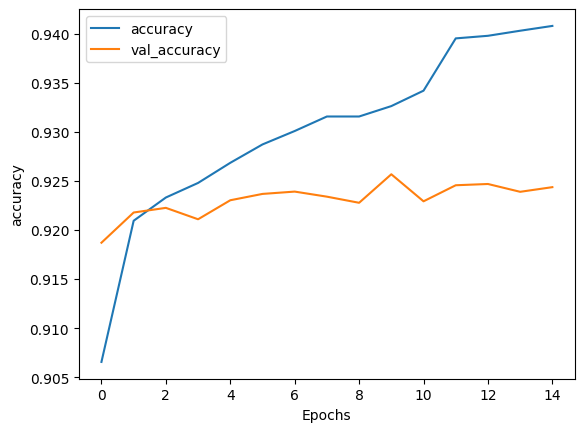

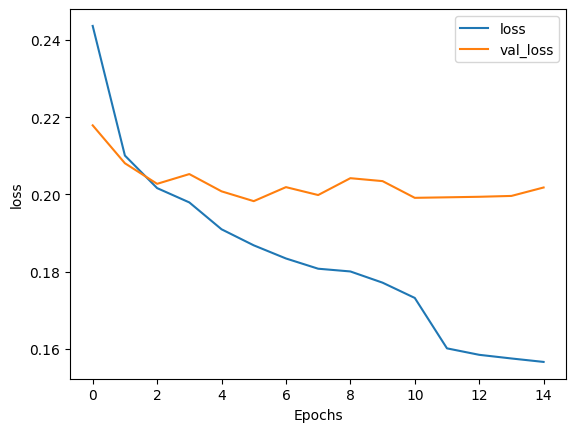

In [17]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing Model

In [18]:
# Load all model
BiLSTM1L_Model = tf.keras.models.load_model('Bidirectional-LSTM-1-Layers.h5')

## Testing BiLSTM 1 Layers

In [19]:
# Define the tweet
twt = ['I will kill myself']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Predict the sentiment
prediction = BiLSTM1L_Model.predict(twt)

# Print the prediction
if(np.argmax(prediction) == 0):
    print("Potential Suicide Post")
elif (np.argmax(prediction) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 521ms/step
Potential Suicide Post
